In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import gzip

In [2]:
# Фиксируем seed для воспроизводимости результатов
torch.manual_seed(42) #  для cpu
#torch.cuda.manual_seed(42)    # для gpu
np.random.seed(42) #  для numpy

In [3]:

f = gzip.open('train-images-idx3-ubyte.gz','r')


image_size = 16
num_images = 100000

# Первые 16 байтов не содержат данные датасета поэтому сначала считываем их, потом всё остальное
f.read(16)

# Считываем данные из файла. Потом решейпим их.
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
print(data.shape)

(100000, 16, 16, 1)


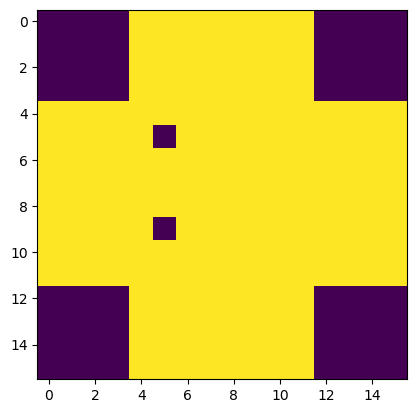

In [4]:
# Выведем и отрисуем один объект из набора данных чтобы просто посмотреть.
image = np.asarray(data[99000]).squeeze()

fig, ax = plt.subplots()
ax.imshow(image)
plt.show()

In [5]:
# Откроем файл с метками. Выведем 1000 меток, чтобы просто посмотреть. 
f = gzip.open('train-labels-idx1-ubyte.gz','r')
f.read(8)
buf = f.read()
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(len(labels))
print(labels[9000:10000])       

100000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0

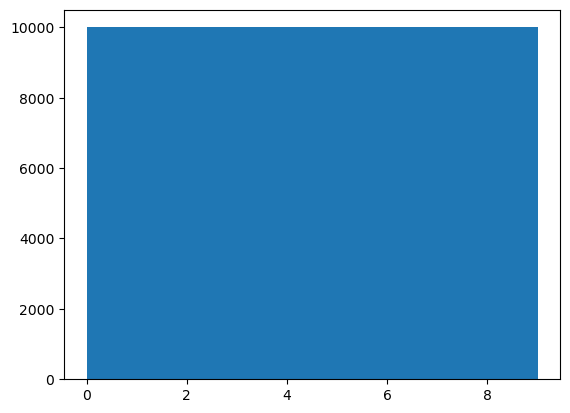

In [6]:
# Посмотрим сбалансированы ли классы.
plt.hist(labels)
plt.show()

In [7]:
# Классы сбалансированы.Количество картинок каждой цифры одинаковое, по 10 000 на каждый класс.

In [8]:
data = data.reshape(num_images, 1, image_size, image_size)
print(data.shape)

# Отщипнем 1 пример (последний) чтобы вывести это изображение и результат обученной модели по нему.
data_train = data[0:99999]
test = data[99999:]

labels = labels[0:99999]

(100000, 1, 16, 16)


In [9]:
# Разделим наши данные на часть для обучения и на часть для проверки, как наша модель обучилась. 
train0, val0, train_labels0, val_labels0 = train_test_split(data_train, labels,
                                                                    train_size=0.9, shuffle=True)
# Делаем торчевские тензоры из наших данных
train0 = torch.FloatTensor(train0) 
train_labels0 = torch.LongTensor(train_labels0) 
val0 = torch.FloatTensor(val0)
val_labels0 = torch.LongTensor(val_labels0)

# Собираем признаки и метки в один тензор
train = TensorDataset(train0, train_labels0)
val = TensorDataset(val0, val_labels0)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, drop_last=True)

In [10]:
# Выбираем девайс на котром будет происходить обучение
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Создаём класс для нейросети. Архитектура сети Lenet.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2, 2))  
        self.conv2 = nn.Conv2d(6, 16, 3)  
        self.relu2 = nn.ReLU()                          
        self.pool2 = nn.MaxPool2d((2, 2))  
        self.flatten = nn.Flatten()                         
        
        self.fc1 = nn.Linear(16*2*2, 120)  
        self.relu3 = nn.ReLU()                          
        self.fc2 = nn.Linear(120, 84) 
        self.relu4 = nn.ReLU()                          
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):
        x =  self.conv1(x)
        x =  self.relu1(x)       
        x = self.pool1(x)
        x = self.conv2(x)                          
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)                          
        x = self.relu4(x)                          
        x = self.fc3(x)                          
        
        return x

In [12]:
# модель - экземпляр класса
model = LeNet().to(device)

# Лосс функция. Она будет задавать поверхность ошибок по которой мы будем двигаться и искать минимум с помощью градиентного спуска. 
criterion = nn.CrossEntropyLoss()

# Оптимизатор. Отвечает за то, как будут обновляться веса нашей модели. Разные оптимизаторы- разные формулы обновления весов.
# Обычно из коробки хорошо работает адам - адаптивный момент.
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_loader, "valid": val_loader}

print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=64, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
# Обучим нашу модель на 10 эпохах.
# Вообще Accuracy такая себе метрика. Но у нас классы сбалансированы, поэтому можно применить Accuracy.

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
          
    
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                
            preds = outp.argmax(-1)
            correct = preds.eq(y_batch.data.view_as(preds)).bool().int().sum() 
            all = batch_size  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9969327880512091
Loader: valid. Accuracy: 1.0
Epoch: 2
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 1.0
Epoch: 3
Loader: train. Accuracy: 0.999399893314367
Loader: valid. Accuracy: 1.0
Epoch: 4
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 1.0
Epoch: 5
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 1.0
Epoch: 6
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 1.0
Epoch: 7
Loader: train. Accuracy: 0.9997332859174964
Loader: valid. Accuracy: 1.0
Epoch: 8
Loader: train. Accuracy: 0.9999333214793741
Loader: valid. Accuracy: 1.0
Epoch: 9
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 1.0
Epoch: 10
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 1.0


In [ ]:
# Метрика Accuracy на проверочной части получилась 1. Хм...

In [20]:
lenet_accuracy_val = accuracy["valid"]
lenet_accuracy_train = accuracy["train"]

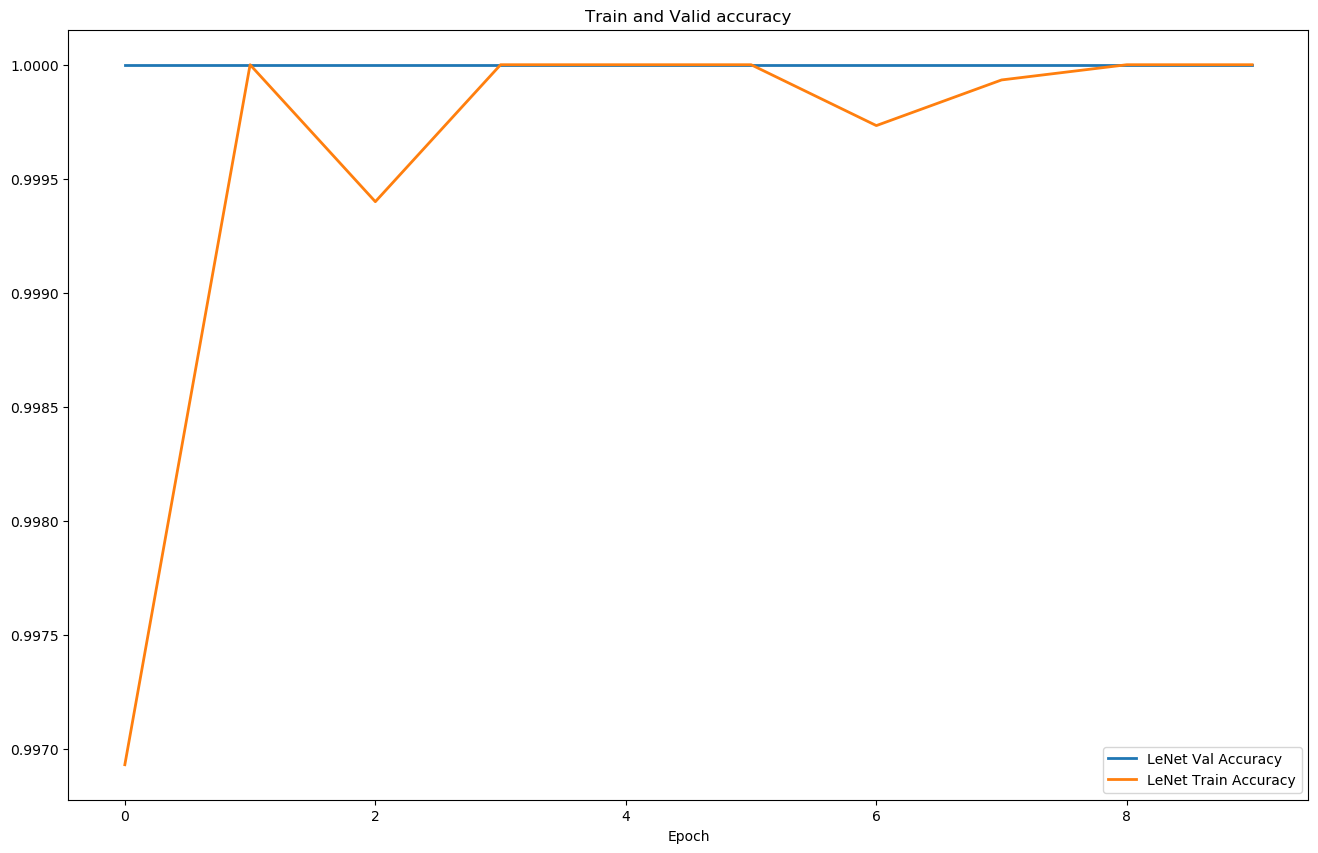

In [21]:
# Выведем графики лосса на тренировочной и проверочной части нашего датасета.
plt.figure(figsize=(16, 10))
plt.title("Train and Valid accuracy")
plt.plot(range(max_epochs), lenet_accuracy_val, label="LeNet Val Accuracy", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy_train, label="LeNet Train Accuracy", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Индекс класса 9


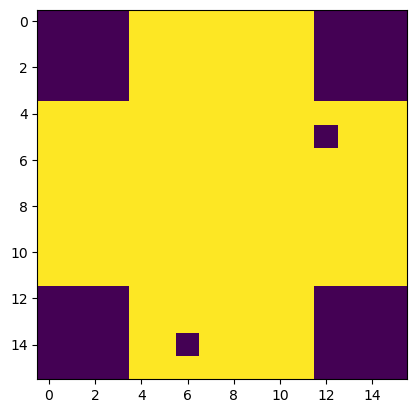

In [23]:
# Теперь посмотрим, как работает обученная модель. Мы зарезервировали ранее 1 пример, который не участвовал в обучении.
# Выведем картинку и мнение модели.
test = test.reshape(1,1, 16, 16)
test = torch.FloatTensor(test)

out = model(test)
print("Индекс класса", int(out.argmax()))

fig, ax = plt.subplots()
ax.imshow(test.reshape(16,16))
plt.show()

In [ ]:
#Теперь вспомним как выглядели классы наших примеров.

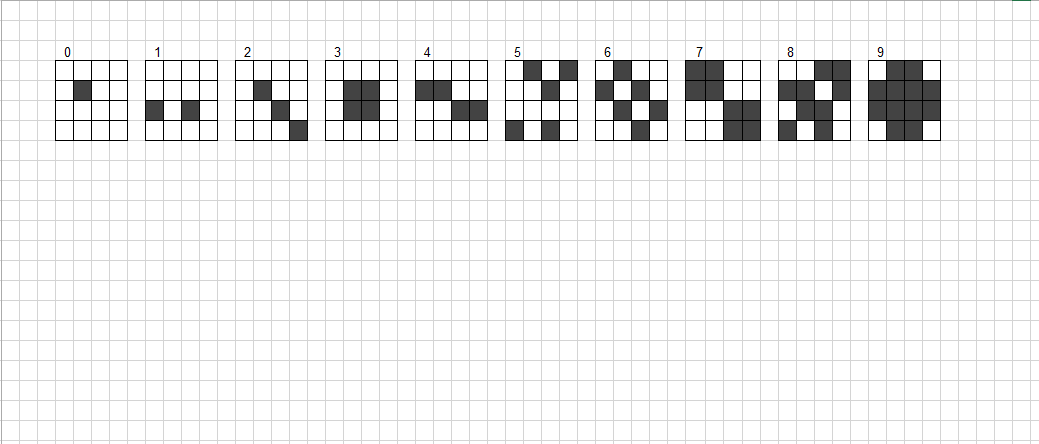

In [ ]:
# Видим что модель правильно классифицировала картинку, как относящуюся к 9 классу.